[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kevin7261/Geographic-Data-Science-with-Python/blob/main/全域空間自相關.ipynb)

# 全域空間自相關

## [1] 上傳資料

In [1]:
# @title <介面> 上傳shp檔案

from google.colab import files
import os

def upload_geojson():
  print("請選擇要上傳的 geojson 檔案。若上傳同名檔案，將會自動覆寫。")
  uploaded = files.upload()
  for uploaded_filename in uploaded.keys():
    if uploaded_filename.endswith('.geojson'):
      # 檢查是否需要處理 Colab 自動重新命名的情況
      if uploaded_filename.endswith(').geojson'):
          # 嘗試找出原始檔名
          original_filename = uploaded_filename.rsplit('(', 1)[0].strip() + '.geojson'
          if os.path.exists(original_filename):
              os.remove(original_filename) # 刪除舊檔案
              print(f"Existing file '{original_filename}' overwritten.")
          # 將上傳的檔案重新命名為原始檔名
          os.rename(uploaded_filename, original_filename)
          print(f"已將 '{uploaded_filename}' 重新命名為 '{original_filename}'")
          return original_filename # 返回原始檔名
      else:
         # 如果沒有被自動重新命名，直接返回上傳的檔名
         print(f"已上傳檔案：{uploaded_filename}")
         return uploaded_filename

  print("沒有上傳有效的 geojson 檔案。")
  return None # 沒有上傳或上傳的不是 geojson

FILE_NAME_GEOJSON = upload_geojson()
print("實際檔名：", FILE_NAME_GEOJSON)

請選擇要上傳的 geojson 檔案。若上傳同名檔案，將會自動覆寫。


Saving 15_台南市區_合併位置.geojson to 15_台南市區_合併位置.geojson
已上傳檔案：15_台南市區_合併位置.geojson
實際使用的檔名： 15_台南市區_合併位置.geojson


In [2]:
# @title <介面> 上傳xlsx檔案

from google.colab import files
import os

def upload_xlsx():
  print("請選擇要上傳的 xlsx 檔案。若上傳同名檔案，將會自動覆寫。")
  uploaded = files.upload()
  for uploaded_filename in uploaded.keys():
    if uploaded_filename.endswith('.xlsx'):
      # 檢查是否需要處理 Colab 自動重新命名的情況
      if uploaded_filename.endswith(').xlsx'):
          # 嘗試找出原始檔名
          original_filename = uploaded_filename.rsplit('(', 1)[0].strip() + '.xlsx'
          if os.path.exists(original_filename):
              os.remove(original_filename) # 刪除舊檔案
              print(f"Existing file '{original_filename}' overwritten.")
          # 將上傳的檔案重新命名為原始檔名
          os.rename(uploaded_filename, original_filename)
          print(f"已將 '{uploaded_filename}' 重新命名為 '{original_filename}'")
          return original_filename # 返回原始檔名
      else:
         # 如果沒有被自動重新命名，直接返回上傳的檔名
         print(f"已上傳檔案：{uploaded_filename}")
         return uploaded_filename

  print("沒有上傳有效的 xlsx 檔案。")
  return None # 沒有上傳或上傳的不是 xlsx

FILE_NAME_XLSX = upload_xlsx()
print("實際檔名：", FILE_NAME_XLSX)

請選擇要上傳的 xlsx 檔案。若上傳同名檔案，將會自動覆寫。


Saving 15_台南市區_合併位置.xlsx to 15_台南市區_合併位置.xlsx
已上傳檔案：15_台南市區_合併位置.xlsx
實際使用的檔名： 15_台南市區_合併位置.xlsx


## [2] 初始設定

In [42]:
# @title 專案設定

PROJECT_NAME = "15_台南市區_合併位置"

WORKSHEET_NAME = "15_台南市區_合併位置"
ANALYSIS_FIELD_NAME = "count"
ANALYSIS_FIELD_NAME_LAG = f"{ANALYSIS_FIELD_NAME}_lag"
ANALYSIS_FIELD_NAME_BINARY = f"{ANALYSIS_FIELD_NAME}_binary"
ANALYSIS_FIELD_NAME_STD = f"{ANALYSIS_FIELD_NAME}_std"
ANALYSIS_FIELD_NAME_LAG_STD = f"{ANALYSIS_FIELD_NAME}_lag_std"

In [43]:
# @title 安裝套件

!pip install -q geopandas gdown
!pip install -q pysal splot contextily
!pip install -q ipywidgets

In [44]:
# @title 下載台北思源黑體

# 下載台北思源黑體，並隱藏輸出
!wget -q -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 匯入必要的庫
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 新增字體
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')

# 設定字體
mpl.rc('font', family='Taipei Sans TC Beta')


In [45]:
# @title 匯入函式庫

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

## [3] 資料處理

### 載入資料

In [46]:
# @title 載入xlsx

ref = pandas.read_excel(FILE_NAME_XLSX, sheet_name=WORKSHEET_NAME).set_index("name")

#ref.head()

In [47]:
# @title 載入geojson

lads = geopandas.read_file(
    FILE_NAME_GEOJSON,
).set_index("CODEBASE")
#lads.info()

#print(lads.crs) # EPSG:4979 Geodetic 3D coordinate system

lads.set_crs(epsg=3826, inplace=True, allow_override=True) # EPSG:3826 TWD97

#print(lads.crs)

,U_ID,CODE1,CODE2,TOWN_ID,TOWN,COUNTY_ID,COUNTY,X,Y,AREA,geometry
CODEBASE,,,,,,,,,,,
A6733-0874-00,5144,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166172.65021,2.535587e+06,25735.24733,"POLYGON Z ((166321.261 2535692.982 0, 166319 2..."
A6733-0878-00,5145,A6733-44-006,A6733-44,67000330,南區,67000,臺南市,165903.12757,2.535458e+06,73573.78885,"POLYGON Z ((165968.38 2535639.042 0, 165978.83..."
A6733-0876-00,5146,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166223.37937,2.535525e+06,20277.53652,"POLYGON Z ((166317.999 2535628.685 0, 166318.5..."
A6732-0998-00,4736,A6732-60-005,A6732-60,67000320,東區,67000,臺南市,171126.85822,2.540743e+06,12151.50679,"POLYGON Z ((171065.623 2540812.968 0, 171117.3..."
A6733-0546-00,4737,A6733-28-006,A6733-28,67000330,南區,67000,臺南市,166383.60272,2.540732e+06,24429.37370,"POLYGON Z ((166306.724 2540811.815 0, 166306.9..."
...,...,...,...,...,...,...,...,...,...,...,...
A6735-0775-00,779,A6735-38-005,A6735-38,67000350,安南區,67000,臺南市,166362.82568,2.549376e+06,19304.15704,"POLYGON Z ((166374.559 2549491.189 0, 166412.8..."
A6735-0759-00,780,A6735-26-005,A6735-26,67000350,安南區,67000,臺南市,167482.77750,2.549442e+06,7543.19820,"POLYGON Z ((167445.095 2549487.087 0, 167548.8..."
A6735-0769-00,781,A6735-30-005,A6735-30,67000350,安南區,67000,臺南市,166716.06082,2.549388e+06,14166.79920,"POLYGON Z ((166805.218 2549471.521 0, 166790.3..."


In [48]:
# @title 用index欄位合併xlsx與shp

db = (
    geopandas.GeoDataFrame(
        lads.join(ref[[ANALYSIS_FIELD_NAME]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[ # EPSG:3857 Spherical Mercator
        [ANALYSIS_FIELD_NAME, "geometry"]
    ]
    #.dropna()
)

#db.info()

# @title 空值填0
db[ANALYSIS_FIELD_NAME] = db[ANALYSIS_FIELD_NAME].fillna(0)

### 繪製資料

In [49]:
# @title <介面> 繪製資料地圖

from ipywidgets import Dropdown, FloatSlider, Button, Output, VBox
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib
import contextily

all_colormaps = sorted(matplotlib.colormaps())

available_schemes = [
    "equalinterval", "quantiles", "fisherjenks",
    "naturalbreaks", "headtailbreaks", "maxp", "boxplot"
]

scheme_widget = Dropdown(
    options=available_schemes,
    value="quantiles",
    description="分級方法：",
    style={'description_width': 'initial'}
)

cmap_widget = Dropdown(
    options=all_colormaps,
    value="viridis",
    description="色帶：",
    style={'description_width': 'initial'}
)

alpha_slider = FloatSlider(
    value=0.75,
    min=0.0,
    max=1.0,
    step=0.05,
    description='透明度：',
    readout_format='.2f',
    style={'description_width': 'initial'}
)

execute_button = Button(
    description='確定',
    button_style='primary',
    icon='paint-brush'
)

output_widget = Output()

display(VBox([
    scheme_widget,
    cmap_widget,
    alpha_slider,
    execute_button,
    output_widget
]))

def on_button_clicked(b):
    selected_scheme = scheme_widget.value
    selected_cmap = cmap_widget.value
    selected_alpha = alpha_slider.value

    with output_widget:
        clear_output(wait=True)

        # -----------------------------------------------

        print(f"\n分級方法: {selected_scheme}")
        print(f"色帶: {selected_cmap}")
        print(f"透明度: {selected_alpha}")

        f, ax = plt.subplots(1, figsize=(9, 9))

        db[db[ANALYSIS_FIELD_NAME] == 0].plot(
            color="lightgray",
            edgecolor="white",
            linewidth=0.2,
            alpha=selected_alpha,
            ax=ax
        )

        db[db[ANALYSIS_FIELD_NAME] > 0].plot(
            column=ANALYSIS_FIELD_NAME,
            cmap=selected_cmap,
            scheme=selected_scheme,
            k=5,
            edgecolor="white",
            linewidth=0.2,
            alpha=selected_alpha,
            legend=True,
            legend_kwds={"loc": "upper left"},
            ax=ax
        )

        contextily.add_basemap(
            ax,
            crs=db.crs,
            source=contextily.providers.CartoDB.PositronNoLabels,
            zoom=13
        )

        ax.set_axis_off()
        ax.set_title(f"{ANALYSIS_FIELD_NAME}")

        # -----------------------------------------------

        plt.tight_layout()
        plt.show()

execute_button.on_click(on_button_clicked)
on_button_clicked(None)


## [4] 開始分析

In [96]:
# @title <介面> 設定最近鄰居數與權重轉換方式以建立空間權重矩陣 w

from ipywidgets import IntText, Dropdown, Button, Output, VBox
from IPython.display import display, clear_output
from libpysal import weights

# ✅ 最近鄰居數輸入框（IntText）
knn_input = IntText(
    value=8,
    description='最近鄰居數：',
    style={'description_width': 'initial'}
)

# ✅ transform 下拉選單（含所有可用選項）
transform_widget = Dropdown(
    options=[
        ("R - Row-standardized（行標準化）", "R"),
        ("B - Binary（0/1）", "B"),
        ("D - Inverse Distance（距離倒數）", "D"),
        ("U - Row-sum Unstandardized（原始加總）", "U"),
        ("V - Variance-stabilizing", "V"),
        ("O - Original（不處理）", "O")
    ],
    value="R",
    description="計算方式：",
    style={'description_width': 'initial'}
)

# ✅ 執行按鈕
execute_button = Button(
    description='確定',
    button_style='primary',
    icon='sitemap'
)

# ✅ 輸出區域
output_widget = Output()

# ✅ 顯示介面
display(VBox([
    knn_input,
    transform_widget,
    execute_button,
    output_widget
]))

# ✅ 點擊事件
def on_button_clicked(b):
    selected_k = knn_input.value
    selected_transform = transform_widget.value

    with output_widget:
        clear_output(wait=True)

        print(f"\n最近鄰居數：{selected_k}")
        print(f"選擇的轉換方式：{selected_transform}")

        # ✅ 建立空間權重矩陣
        global w
        w = weights.KNN.from_dataframe(db, k=selected_k)
        w.transform = selected_transform

        print(f"空間權重矩陣建立成功，區塊數量：{len(w.neighbors)}")

# ✅ 綁定事件
execute_button.on_click(on_button_clicked)

# ✅ 預設執行一次
on_button_clicked(None)


### Spatial lag

In [51]:
# @title 計算Spatial Lag

db[ANALYSIS_FIELD_NAME_LAG] = weights.spatial_lag.lag_spatial(
    w, db[ANALYSIS_FIELD_NAME]
)

#db.loc[["A6737-0210-00", "A6733-0731-00"], [ANALYSIS_FIELD_NAME, ANALYSIS_FIELD_NAME_LAG]]

In [99]:
# @title <介面> 繪製原始值與 Spatial Lag 值（最近鄰居數與轉換方式在最上方）

from ipywidgets import Dropdown, FloatSlider, IntText, Button, Output, VBox
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib
import contextily
from libpysal import weights
from libpysal.weights import spatial_lag

# ✅ 色帶與分級選項
all_colormaps = sorted(matplotlib.colormaps())
available_schemes = [
    "equalinterval", "quantiles", "fisherjenks",
    "naturalbreaks", "headtailbreaks", "maxp", "boxplot"
]

# ✅ 最近鄰居數與轉換方式（放在最上方）
knn_input = IntText(
    value=8,
    description='最近鄰居數：',
    style={'description_width': 'initial'}
)

transform_widget = Dropdown(
    options=[
        ("R - Row-standardized（行標準化）", "R"),
        ("B - Binary（0/1）", "B"),
        ("D - Inverse Distance（距離倒數）", "D"),
        ("U - Row-sum Unstandardized（原始加總）", "U"),
        ("V - Variance-stabilizing", "V"),
        ("O - Original（不處理）", "O")
    ],
    value="R",
    description="轉換方式：",
    style={'description_width': 'initial'}
)

# ✅ 其他元件
scheme_widget = Dropdown(
    options=available_schemes,
    value="quantiles",
    description="分級方法：",
    style={'description_width': 'initial'}
)

cmap_widget = Dropdown(
    options=all_colormaps,
    value="viridis",
    description="色帶：",
    style={'description_width': 'initial'}
)

alpha_slider = FloatSlider(
    value=0.75,
    min=0.0,
    max=1.0,
    step=0.05,
    description='透明度：',
    readout_format='.2f',
    style={'description_width': 'initial'}
)

execute_button = Button(
    description='確定',
    button_style='primary',
    icon='paint-brush'
)

output_widget = Output()

# ✅ 顯示 UI（順序調整：k、transform 放最上）
display(VBox([
    knn_input,
    transform_widget,
    scheme_widget,
    cmap_widget,
    alpha_slider,
    execute_button,
    output_widget
]))

# ✅ 點擊繪圖
def on_button_clicked(b):
    selected_scheme = scheme_widget.value
    selected_cmap = cmap_widget.value
    selected_alpha = alpha_slider.value
    selected_k = knn_input.value
    selected_transform = transform_widget.value

    with output_widget:
        clear_output(wait=True)

        print(f"\n最近鄰居數：{selected_k}")
        print(f"轉換方式：{selected_transform}")
        print(f"分級方法：{selected_scheme}")
        print(f"色帶：{selected_cmap}")
        print(f"透明度設定：{selected_alpha}")

        # ✅ 建立空間權重矩陣 w 並計算滯後值
        global w
        w = weights.KNN.from_dataframe(db, k=selected_k)
        w.transform = selected_transform
        db["count_lag"] = spatial_lag.lag_spatial(w, db[ANALYSIS_FIELD_NAME])

        # ✅ 繪製地圖
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

        db.plot(
            column=ANALYSIS_FIELD_NAME,
            cmap=selected_cmap,
            scheme=selected_scheme,
            k=5,
            edgecolor="white",
            linewidth=0.2,
            alpha=selected_alpha,
            legend=True,
            legend_kwds={"loc": "upper left"},
            ax=ax1,
        )
        contextily.add_basemap(
            ax1,
            crs=db.crs,
            source=contextily.providers.CartoDB.PositronNoLabels,
            zoom=13
        )
        ax1.set_axis_off()
        ax1.set_title(f"{ANALYSIS_FIELD_NAME}")

        db.plot(
            column="count_lag",
            cmap=selected_cmap,
            scheme=selected_scheme,
            k=5,
            edgecolor="white",
            linewidth=0.2,
            alpha=selected_alpha,
            legend=True,
            legend_kwds={"loc": "upper left"},
            ax=ax2,
        )
        contextily.add_basemap(
            ax2,
            crs=db.crs,
            source=contextily.providers.CartoDB.PositronNoLabels,
            zoom=13
        )
        ax2.set_axis_off()
        ax2.set_title(f"{ANALYSIS_FIELD_NAME} - Spatial Lag (k={w.k}, transform={w.transform})")

        plt.tight_layout()
        plt.show()

# ✅ 綁定事件
execute_button.on_click(on_button_clicked)
on_button_clicked(None)


### Binary case

In [53]:
# @title <介面> 輸入二元分隔值

from ipywidgets import IntText, Button, Output, HBox, VBox # 引入 VBox
from IPython.display import display, clear_output

count_range = (db[ANALYSIS_FIELD_NAME].min(), db[ANALYSIS_FIELD_NAME].max())
# 移除 print(f"{ANALYSIS_FIELD_NAME}範圍：{int(count_range[0])} - {int(count_range[1])}")

# 計算中間值作為預設值
default_binary_value = int((count_range[0] + count_range[1]) / 2)

# 創建一個帶有預設值的 IntText 輸入框
binary_value_widget = IntText(
    value=default_binary_value,  # 設定預設值
    description='分隔值：', # 只保留分隔值描述
    disabled=False,
    style={'description_width': 'initial'} # 讓 description 完整顯示
)

# 創建一個 HTML widget 顯示範圍資訊
from ipywidgets import HTML
range_html = HTML(value=f"({int(count_range[0])} - {int(count_range[1])})")

# 創建一個按鈕
execute_button = Button(
    description='確定',
    disabled=False,
    button_style='primary', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='點擊以根據分隔值進行二元化並繪圖',
    icon='check' # (FontAwesome icons available: https://fontawesome.com/icons?d=gallery&c=all&v=4.7.0)
)

# 創建一個 Output widget 用來顯示結果
output_widget = Output()

# 使用 HBox 將輸入框和範圍資訊放在同一行
input_and_range = HBox([binary_value_widget, range_html])

# 使用 VBox 將 HBox、按鈕和輸出區域垂直排列
input_area = VBox([input_and_range, execute_button])

# 顯示 widget
display(input_area, output_widget)

# 定義一個函數，當按鈕點擊時執行
def on_button_clicked(b):
    global binary_value # 宣告使用全域變數
    binary_value = binary_value_widget.value # 從輸入框獲取分隔值

    with output_widget:
        clear_output(wait=True) # 清除之前的輸出
        # 這裡放你想要重新執行的程式碼

        # ----------------------------------------

        db[ANALYSIS_FIELD_NAME_BINARY] = (db[ANALYSIS_FIELD_NAME] > binary_value).astype(int)
        # db[[ANALYSIS_FIELD_NAME, "count_binary"]].tail()

        # ----------------------------------------

        print(f"\n分隔值: {binary_value}")

        f, ax = plt.subplots(1, figsize=(9, 9))
        db.plot(
            ax=ax,
            column=ANALYSIS_FIELD_NAME_BINARY,
            categorical=True,
            legend=True,
            edgecolor="0.5",
            linewidth=0.25,
            cmap="Set3",
            figsize=(9, 9),
        )
        ax.set_axis_off()
        ax.set_title(f"{ANALYSIS_FIELD_NAME} Binary (Threshold: {binary_value})")
        plt.axis("equal")
        plt.show()

        # ----------------------------------------

# 將 on_button_clicked 函數連結到按鈕的 on_click 事件
execute_button.on_click(on_button_clicked)

# (可選) 在 notebook 加載時，先執行一次以顯示預設值下的圖
on_button_clicked(None) # 如果需要預設顯示，取消這行的註解

Output()

In [77]:
# 設定權重轉換方式
w.transform = "O" # 這是設定 PySAL 的空間權重矩陣 w 的權重轉換方式為 "O"，也就是：✅ 不做任何標準化處理，保留原始的權重值。
#w.transform = "R" # 這是設定 PySAL 的空間權重矩陣 w 的權重轉換方式為 "O"，也就是：✅ 不做任何標準化處理，保留原始的權重值。

In [91]:
seed(1234)
jc = esda.join_counts.Join_Counts(db[ANALYSIS_FIELD_NAME_BINARY], w)
print(f"G-G（同為 1 的鄰接對，例如兩塊綠地）數量：{jc.bb}")
print(f"Y-Y（同為 0 的鄰接對，例如兩塊非綠地）數量：{jc.ww}")
print(f"G-Y（不同類別的鄰接對，例如綠地與非綠地相鄰）數量：{jc.bw}")

print(f"所有鄰接對的總數（G-G + Y-Y + G-Y）：{jc.bb + jc.ww + jc.bw}")

print(f"G-G 模擬平均值（若隨機分布時預期出現的 G-G 數量）：{jc.mean_bb}")
print(f"G-Y 模擬平均值（若隨機分布時預期出現的 G-Y 數量）：{jc.mean_bw}")

print(f"G-G 模擬 p 值（若小於 0.05，代表 G 類有顯著聚集）：{jc.p_sim_bb}")
print(f"G-Y 模擬 p 值（若小於 0.05，代表 G 與 Y 類有顯著空間隔離）：{jc.p_sim_bw}")

G-G（同為 1 的鄰接對，例如兩塊綠地）數量：3359.5
Y-Y（同為 0 的鄰接對，例如兩塊非綠地）數量：12125.5
G-Y（不同類別的鄰接對，例如綠地與非綠地相鄰）數量：5099.0
所有鄰接對的總數（G-G + Y-Y + G-Y）：20584.0
G-G 模擬平均值（若隨機分布時預期出現的 G-G 數量）：1678.6511511511512
G-Y 模擬平均值（若隨機分布時預期出現的 G-Y 數量）：8401.507507507507
G-G 模擬 p 值（若小於 0.05，代表 G 類有顯著聚集）：0.001
G-Y 模擬 p 值（若小於 0.05，代表 G 與 Y 類有顯著空間隔離）：1.0


### Moran Plot and Moran’s I

In [90]:
# @title 計算標準差
db[ANALYSIS_FIELD_NAME_STD] = db[ANALYSIS_FIELD_NAME] - db[ANALYSIS_FIELD_NAME].mean() # 標準差
db[ANALYSIS_FIELD_NAME_LAG_STD] = weights.lag_spatial(
    w, db[ANALYSIS_FIELD_NAME_STD]
)

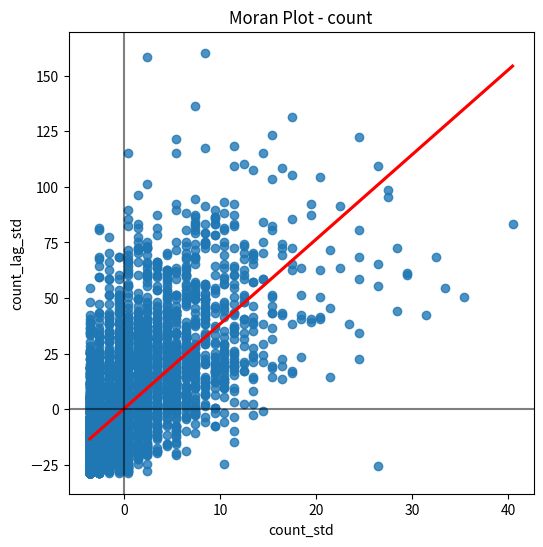

In [82]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x=ANALYSIS_FIELD_NAME_STD,
    y=ANALYSIS_FIELD_NAME_LAG_STD,
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title(f"Moran Plot - {ANALYSIS_FIELD_NAME}")
plt.show()

In [58]:
w.transform = "R" # ✅ 將空間權重矩陣 w 標準化為「行標準化（Row-standardized）」
moran = esda.moran.Moran(db[ANALYSIS_FIELD_NAME], w)

In [84]:
print(f"moran.I: {moran.I}")
print(f"moran.p_sim: {moran.p_sim}") # ✅ 結果具有統計顯著性（空間自相關成立）

moran.I: 0.47650921385047795
moran.p_sim: 0.001


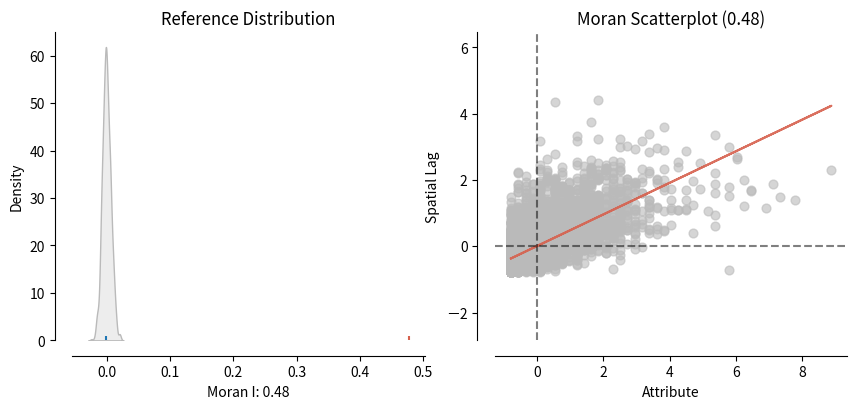

In [61]:
plot_moran(moran);

### Geary’s C

In [62]:
geary = esda.geary.Geary(db[ANALYSIS_FIELD_NAME], w)

In [85]:
print(f"geary.C: {geary.C}") # 正向空間自相關（鄰近值相似）
print(f"geary.p_sim: {geary.p_sim}")

geary.C: 0.5160330680243552
geary.p_sim: 0.001


### Getis and Ord’s G

In [86]:
# 某個地點周圍是否形成高值或低值的集群。
db_osgb = db.to_crs(epsg=3826) # epsg=3826 TWD97 / epsg=27700 British National Grid
pts = db_osgb.centroid
xys = pandas.DataFrame({"X": pts.x, "Y": pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr # 找出「使得每個點至少有一個鄰居」所需的最小距離 d」

np.float64(1158.8580564338865)

In [87]:
w_db = weights.DistanceBand.from_dataframe(db_osgb, min_thr)

/usr/local/lib/python3.11/dist-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: A6735-0725-00.
  w = W(neighbors, weights, ids, **kwargs)
/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: A6735-0725-00.
  W.__init__(


In [88]:
gao = esda.getisord.G(db[ANALYSIS_FIELD_NAME], w_db)

In [89]:
print(
    "Getis & Ord G: %.3f | Pseudo P-value: %.3f" % (gao.G, gao.p_sim)
)

Getis & Ord G: 0.099 | Pseudo P-value: 0.001
